In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import k_means, AgglomerativeClustering
from itertools import product

# Statystyki oceniające jakość działania algorytmów analizy skupień

## Rodzaje algorytmów poddane analizie
* **KMeans** - na podstawie zadanej liczby klastrów $nc$ generuje losowo $nc$ centroidów, które reprezentuję klasy skupień. W następnych krokach centroidy przesuwane są w pozycję wyliczoną na podstawie średniej z punktów należących do klasy skupienia.
* **Hierarchical Clustering (Ward linkage)** - w przeciwieństwie do KMeans, dane nie muszą być reprezentowane w przestrzeni metrycznej, do działania algorytmów hierarchicznej analizy skupień potrzebne są tylko metryki odległości pomiędzy punktami danych.

## Rodzaje statystyk

### External criteria - na bazie wiedzy o prawdziwym podziale danych
#### Wstępne oznaczenia
* SS - jeżeli punkty należą do tego samego klastru i zostały poprawnie skojarzone przez algorytm
* SD - jeżeli punkty należą do tego samego klastru i nie zostały skojarzone przez algorytm
* DS - jeżeli punkty należą do różnych klastrów i zostały skojarzone przez algorytm
* DD - jeżeli punkty należą do różnych klastrów i algorytm nie skojarzył ich ze sobą

oznaczymy kolejno $a,b,c,d$ jako SS, SD, DS i DD. Ponadto niech $M = a + b + c + d$

#### Statystyki
* Rand Statistic (sklearn: ✔️, własne: ✔️): $R = \frac{a+d}{M}$
* Jaccard Coefficient (sklearn: ✖️, własne: ✔️) $J = \frac{a}{a+b+c}$
* Folkes and Mallows index (sklearn: ✔️, własne: ✔️) $FM = \frac{a}{\sqrt{(a+b)(a+c)}}$

### Internal criteria - wyłącznie na bazie wiedzy o kształcie zbioru danych i powstałych skupień
* Huberts $\Gamma$ statistic (sklearn: ✖️, własne: ✔️) $\Gamma = \frac{1}{M}\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} X(i,j)Y(i,j)$

Przy czym $X$ = macierz odległości i $Y$ macierzą zer i jedynek, dla których $Y[i,j] = 1$ jeżeli $i$-ty i $j$-ty record należy do tego samego klastra

## Przykład wykorzystania internal i external criteria przy teście statystycznym

* Generuję cztery zbiory punktów z dwuwymiarowego rozkładu normalnego (w pierwszym przykładzie o macierzy kowariancji $0.2 I$, w drugim $4I$), kolejno o środkach w $(0,0),(0,1),(1,0),(1,1)$ - podział określam na podstawie przynależności do wygenerowanego zbioru
* Przy pomocy wybranego algorytmu rozdzielam dane na klastry i dla znalezionego podziału wyliczam wybrane statystyki
* Zakładam hipotezę zerową z poziomem istotności $\alpha = 0.05$ - w danych nie ma żadnych skupień
* 100 razy generuję dane z rozkładu jednostajnego w przestrzeni danych wejściowych i nadaję im etykiety z podziału wejściowego, dokonuję na nich analizę skupień i wyliczam statystyki
* Porównuję statystyki z wyliczonymi dla pierwotnych danych, liczę ile z losowo generowanych przykładów daje gorsze wyniki niż prawdziwe dane.
* Na podstawie zliczonych wyników przyjmuję lub odrzucam hipotezę zerową

In [12]:
def evaluate_clustering(clusters, partition):
    n = len(clusters)

    counter_dict = {
        "SS":0,
        "SD":0,
        "DS":0,
        "DD":0
    }

    for i in range(n):
        for j in range(i+1, n):
            if clusters[i]==clusters[j] and partition[i]==partition[j]:
                counter_dict["SS"]+=1
            elif clusters[i]==clusters[j] and partition[i]!=partition[j]:
                counter_dict["SD"]+=1    
            elif clusters[i]!=clusters[j] and partition[i]==partition[j]:
                counter_dict["DS"]+=1    
            elif clusters[i]!=clusters[j] and partition[i]!=partition[j]:
                counter_dict["DD"]+=1
    
    return counter_dict

def rand_stat(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return (a+d)/(a+b+c+d)

def jacc_coef(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return a/(a+b+c)

def fm_index(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return np.sqrt(a**2/((a+b)*(a+c)))

def gamma_statistic(X,Y):
    N = X.shape[0]
    M = N*(N-1)/2
    return np.sum(np.tril(X*Y,-1))/M

def generate_sample(x_mean, y_mean, x_std=0.2, y_std=0.2, size=100):
    return np.c_[np.random.normal(loc=x_mean,scale=x_std,size=size),np.random.normal(loc=y_mean,scale=y_std,size=size)]

def proximity_matrix(X):
    n = X.shape[0]
    return np.array(list(map(lambda pair: np.linalg.norm(pair[0]-pair[1]), product(X,X)))).reshape(n,n)

def cluster_matrix(clusters):
    n = len(clusters)
    return np.array(list(map(lambda pair: int(pair[0]!=pair[1]), product(clusters,clusters)))).reshape(n,n)

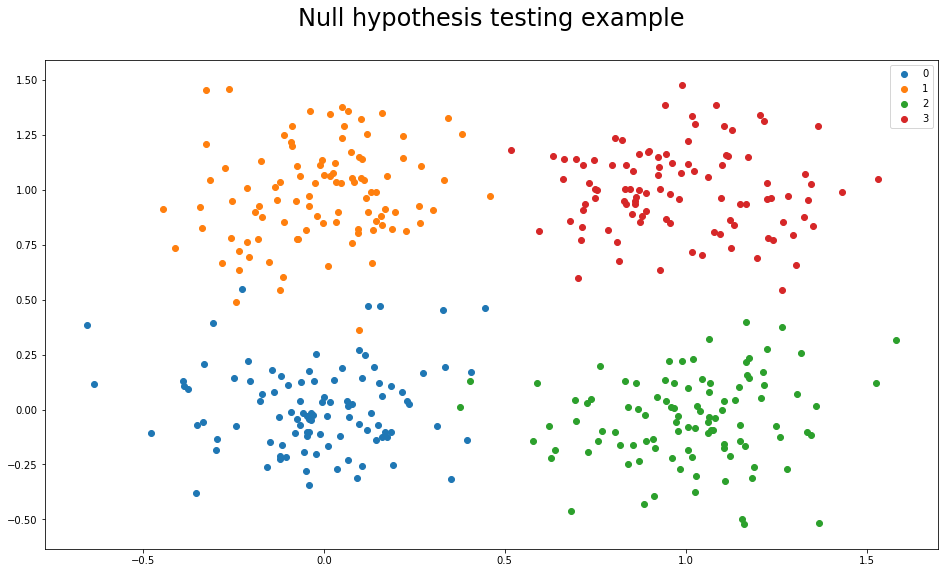

In [31]:
cluster_size = 100

p0 = generate_sample(0,0,size=cluster_size)
p1 = generate_sample(0,1,size=cluster_size)
p2 = generate_sample(1,0,size=cluster_size)
p3 = generate_sample(1,1,size=cluster_size)

X = np.r_[p0,p1,p2,p3]
partition = np.repeat([0,1,2,3],cluster_size)
clusters_kmeans = k_means(X,4)[1]
clusters_ward = AgglomerativeClustering(n_clusters=4).fit_predict(X)

plt.figure(figsize=(16,9))
plt.title("Null hypothesis testing example\n", size=24)
plt.scatter(*p0.transpose())
plt.scatter(*p1.transpose())
plt.scatter(*p2.transpose())
plt.scatter(*p3.transpose())
plt.legend([0,1,2,3])
plt.show()

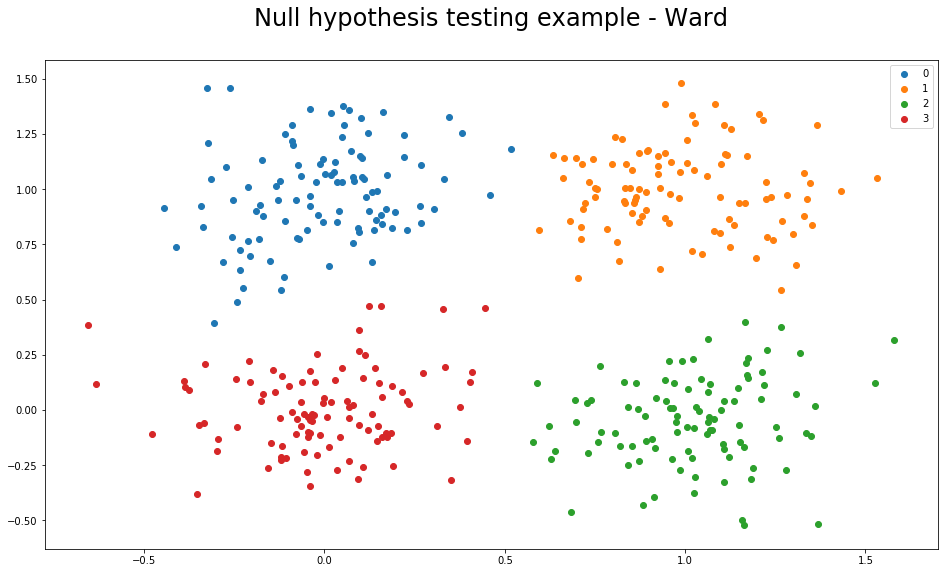

In [37]:
plt.figure(figsize=(16,9))
plt.title("Null hypothesis testing example - Ward\n", size=24)
plt.scatter(*X[clusters_ward==0].transpose(), label = "0")
plt.scatter(*X[clusters_ward==1].transpose(), label = "1")
plt.scatter(*X[clusters_ward==2].transpose(), label = "2")
plt.scatter(*X[clusters_ward==3].transpose(), label = "3")
# plt.colorbar()
plt.legend()
plt.show()

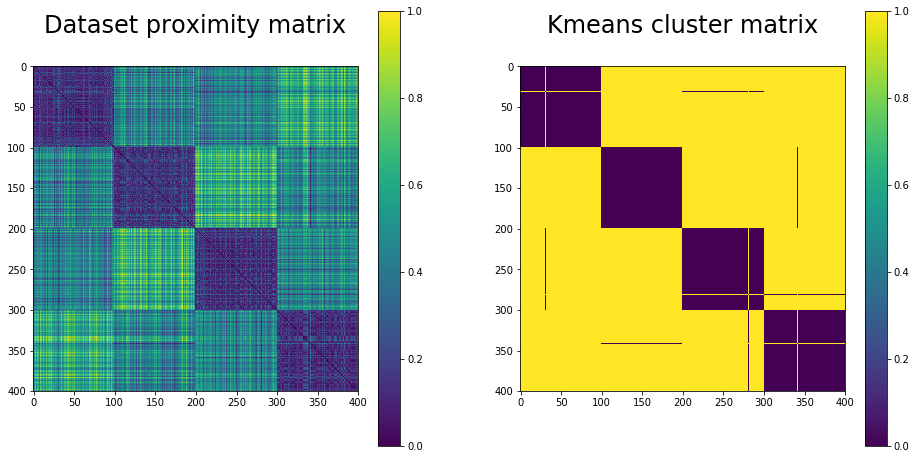

In [21]:
A = proximity_matrix(X)
B = cluster_matrix(clusters_kmeans)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.title("Dataset proximity matrix\n", size=24)
plt.imshow(A/np.max(A))
plt.colorbar()
fig.add_subplot(1,2,2)
plt.title("Kmeans cluster matrix\n", size=24)
plt.imshow(B)
plt.colorbar()
plt.show()

### Hypothesis test

In [26]:
results = pd.DataFrame({
    "Rand":[rand_stat(clusters_kmeans, partition), rand_stat(clusters_ward, partition)],
    "Jacc":[jacc_coef(clusters_kmeans, partition), jacc_coef(clusters_ward, partition)],
    "FM":[fm_index(clusters_kmeans, partition), fm_index(clusters_kmeans, partition)],
    "Huberts Γ": [gamma_statistic(proximity_matrix(X),cluster_matrix(clusters_kmeans)),gamma_statistic(proximity_matrix(X),cluster_matrix(clusters_ward))]},index=["KMeans","Ward"])

x_min, x_max, y_min, y_max = np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])
random_data_results_kmeans = pd.DataFrame(columns=["Rand","Jacc","FM", "Huberts Γ"])
random_data_results_ward = pd.DataFrame(columns=["Rand","Jacc","FM", "Huberts Γ"])
for i in range(100):
    print(f"iteration: {i+1}", end="\r")
    X_random = np.c_[np.random.uniform(x_min, x_max, size=cluster_size*4),np.random.uniform(y_min, y_max, size=cluster_size*4)]
    P = np.repeat([0,1,2,3],100)
    
    C_kmeans = k_means(X_random, 4)[1]
    C_ward = AgglomerativeClustering(n_clusters=4).fit_predict(X_random)
    
    random_data_results_kmeans.loc[i,:] = [rand_stat(C_kmeans,P),jacc_coef(C_kmeans,P),fm_index(C_kmeans,P),gamma_statistic(proximity_matrix(X_random),cluster_matrix(C_kmeans))]
    random_data_results_ward.loc[i,:] = [rand_stat(C_ward,P),jacc_coef(C_ward,P),fm_index(C_ward,P),gamma_statistic(proximity_matrix(X_random),cluster_matrix(C_ward))]

pd.DataFrame({
    "Rand":[sum(random_data_results_kmeans.loc[:,"Rand"] < results.loc["KMeans","Rand"]),sum(random_data_results_ward.loc[:,"Rand"] < results.loc["Ward","Rand"])],
    "Jacc":[sum(random_data_results_kmeans.loc[:,"Jacc"] < results.loc["KMeans","Jacc"]),sum(random_data_results_ward.loc[:,"Jacc"] < results.loc["Ward","Jacc"])],
    "FM":[sum(random_data_results_kmeans.loc[:,"FM"] < results.loc["KMeans","FM"]),sum(random_data_results_ward.loc[:,"FM"] < results.loc["Ward","FM"])],
    "Huberts Γ":[sum(random_data_results_kmeans.loc[:,"Huberts Γ"] > results.loc["KMeans","Huberts Γ"]),sum(random_data_results_ward.loc[:,"Huberts Γ"] > results.loc["Ward","Huberts Γ"])]
},index=["KMeans_test","Ward_test"])

,Rand,Jacc,FM,Huberts Γ
KMeans_test,100,100,100,99
Ward_test,100,100,100,89


### wszystkie wartości są większe niż $(1-\alpha)r=0.95\times100=95$, więc możemy odrzucić hipotezę zerową

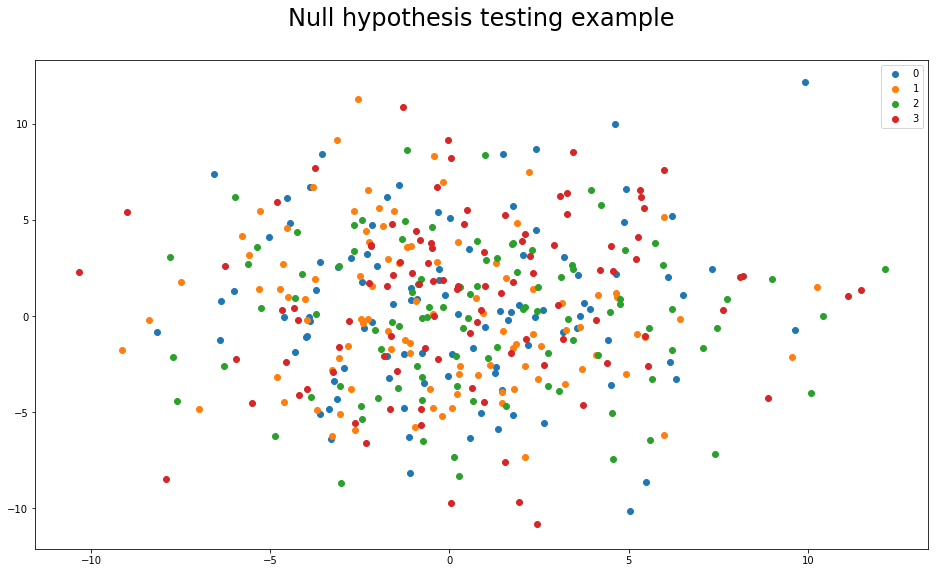

In [27]:
cluster_size = 100

p0 = generate_sample(0,0,4,4,size=cluster_size)
p1 = generate_sample(0,1,4,4,size=cluster_size)
p2 = generate_sample(1,0,4,4,size=cluster_size)
p3 = generate_sample(1,1,4,4,size=cluster_size)

X = np.r_[p0,p1,p2,p3]
partition = np.repeat([0,1,2,3],cluster_size)
clusters_kmeans = k_means(X,4)[1]
clusters_ward = AgglomerativeClustering(n_clusters=4).fit_predict(X)

plt.figure(figsize=(16,9))
plt.title("Null hypothesis testing example\n", size=24)
plt.scatter(*p0.transpose())
plt.scatter(*p1.transpose())
plt.scatter(*p2.transpose())
plt.scatter(*p3.transpose())
plt.legend([0,1,2,3])
plt.show()

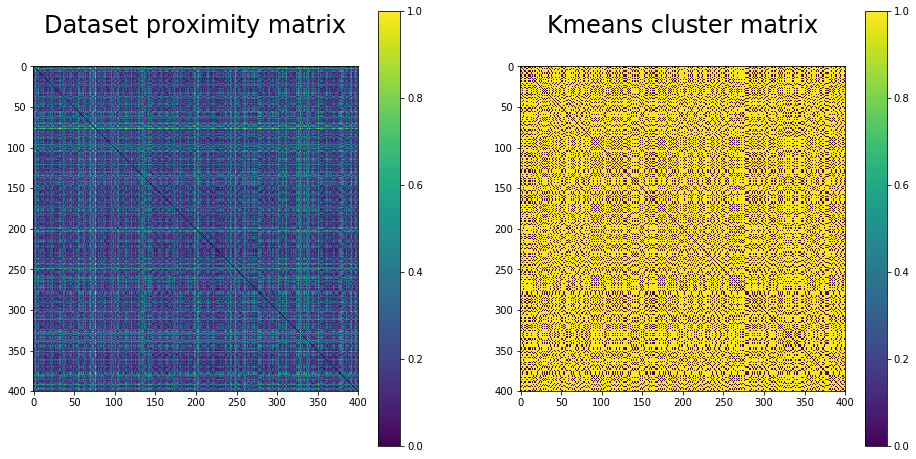

In [28]:
A = proximity_matrix(X)
B = cluster_matrix(clusters_kmeans)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.title("Dataset proximity matrix\n", size=24)
plt.imshow(A/np.max(A))
plt.colorbar()
fig.add_subplot(1,2,2)
plt.title("Kmeans cluster matrix\n", size=24)
plt.imshow(B)
plt.colorbar()
plt.show()

### Hypothesis test

In [29]:
results = pd.DataFrame({
    "Rand":[rand_stat(clusters_kmeans, partition), rand_stat(clusters_ward, partition)],
    "Jacc":[jacc_coef(clusters_kmeans, partition), jacc_coef(clusters_ward, partition)],
    "FM":[fm_index(clusters_kmeans, partition), fm_index(clusters_kmeans, partition)],
    "Huberts Γ": [gamma_statistic(proximity_matrix(X),cluster_matrix(clusters_kmeans)),gamma_statistic(proximity_matrix(X),cluster_matrix(clusters_ward))]},index=["KMeans","Ward"])

x_min, x_max, y_min, y_max = np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])
random_data_results_kmeans = pd.DataFrame(columns=["Rand","Jacc","FM", "Huberts Γ"])
random_data_results_ward = pd.DataFrame(columns=["Rand","Jacc","FM", "Huberts Γ"])
for i in range(100):
    print(f"iteration: {i+1}", end="\r")
    X_random = np.c_[np.random.uniform(x_min, x_max, size=cluster_size*4),np.random.uniform(y_min, y_max, size=cluster_size*4)]
    P = np.repeat([0,1,2,3],100)
    
    C_kmeans = k_means(X_random, 4)[1]
    C_ward = AgglomerativeClustering(n_clusters=4).fit_predict(X_random)
    
    random_data_results_kmeans.loc[i,:] = [rand_stat(C_kmeans,P),jacc_coef(C_kmeans,P),fm_index(C_kmeans,P),gamma_statistic(proximity_matrix(X_random),cluster_matrix(C_kmeans))]
    random_data_results_ward.loc[i,:] = [rand_stat(C_ward,P),jacc_coef(C_ward,P),fm_index(C_ward,P),gamma_statistic(proximity_matrix(X_random),cluster_matrix(C_ward))]

pd.DataFrame({
    "Rand":[sum(random_data_results_kmeans.loc[:,"Rand"] < results.loc["KMeans","Rand"]),sum(random_data_results_ward.loc[:,"Rand"] < results.loc["Ward","Rand"])],
    "Jacc":[sum(random_data_results_kmeans.loc[:,"Jacc"] < results.loc["KMeans","Jacc"]),sum(random_data_results_ward.loc[:,"Jacc"] < results.loc["Ward","Jacc"])],
    "FM":[sum(random_data_results_kmeans.loc[:,"FM"] < results.loc["KMeans","FM"]),sum(random_data_results_ward.loc[:,"FM"] < results.loc["Ward","FM"])],
    "Huberts Γ":[sum(random_data_results_kmeans.loc[:,"Huberts Γ"] > results.loc["KMeans","Huberts Γ"]),sum(random_data_results_ward.loc[:,"Huberts Γ"] > results.loc["Ward","Huberts Γ"])]
},index=["KMeans_test","Ward_test"])

,Rand,Jacc,FM,Huberts Γ
KMeans_test,0,91,91,100
Ward_test,49,66,22,100


### $(1-\alpha)r < 95$ dla wielu statystyk zatem nie możemy odrzucić hipotezy zerowej